In [1]:
list.of.packages = c('rpart','caret','ggplot2','randomForest',
                     'tidyverse','ranger','e1071','rpart.plot')
new.packages = list.of.packages[!(list.of.packages 
                      %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages,
                        repos='http://cran.us.r-project.org')

options(warn=-1)
suppressWarnings(library(rpart, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(rpart.plot, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(ggplot2, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(tidyverse, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(ranger, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(e1071, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(caret, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(randomForest, quietly = TRUE, warn.conflicts = FALSE))


-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v tibble  1.4.2     v purrr   0.2.5
v tidyr   0.8.1     v dplyr   0.7.6
v readr   1.1.1     v stringr 1.3.1
v tibble  1.4.2     v forcats 0.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.


### In this module you will learn how to:

1. Build a nonparametric model of house prices using regression trees
2. Examine random forests and what the hyperparameters correspond to


### The Data

In this module we will re-examine the Housing data. However, instead of assuming the model is linear ($Y = X\beta + \varepsilon$) we will be agnostic about functional form, i.e. $Y=g(X)+\varepsilon$. To estimate the unknown function $g(X)$ we will use Regression Trees and Forests.

In [2]:
Housing = read.csv('ahs_clean.csv')   
# Reads csv files into R

cat('Dataset dimesions: ',dim(Housing))                  
# Returns the dimension of the dataset             

Housing$LOGSQFT = log(Housing$UNITSF)
Housing$LOGLOT = log(Housing$LOT)

Housing[1:10,1:10]                                         
# Examine the first few rows and columns of our data                


Dataset dimesions:  51759 212

LOGVALUE,LOT,UNITSF,CLIMB,DIRAC,NUMAIR,BUSPER,EXCLUS,HOWH,NUMCOLD
0.6931472,900,2314.18,2.011952,1.51928,1.730885,0,0,6,1.828194
0.6931472,14520,2500.00,2.011952,1.51928,1.730885,0,0,10,1.828194
0.6931472,11000,7507.00,2.011952,1.51928,1.000000,0,0,9,1.828194
1.6094379,23760,830.00,2.011952,1.51928,1.000000,0,0,10,1.828194
1.6094379,3000,1100.00,2.011952,1.51928,4.000000,0,0,7,1.828194
1.6094379,44000,1000.00,2.011952,1.51928,1.730885,0,0,6,1.828194
1.6094379,220000,2000.00,2.011952,1.51928,1.000000,1,0,8,1.828194
1.6094379,220000,1800.00,2.011952,1.51928,1.730885,0,0,10,1.828194
1.6094379,33000,1200.00,2.011952,1.51928,1.730885,1,0,10,1.828194
1.9459101,44000,1957.00,2.011952,1.51928,1.730885,0,0,8,1.828194


Since we already examined this data, let's go ahead and use the larger model with 60 covariates.

In [3]:
#Splitting the data

data_split = function(data,split=.1){

    N = dim(data)[1]                         
    random = sample(1:N,N,replace=F)          
    # Randomly choose the index for the splits
    data = data[random,]                      
    # Shuffle data
    test = data[1:round(N*split),]            
    # Splits
    train = data[(round(N*split)+1):N,]

    
    return(list(train,test))
}


tmp = data_split(Housing) 
train_test = tmp[[1]]
validation = tmp[[2]]

In [4]:
train1 = train_test[c('LOGVALUE','LOGLOT','LOGSQFT','BEDRMS','BATHS',
                      'REGION','METRO','KITCHEN','DISH','WASH','DRY',
                      'COOK','DENS','DINING','FAMRM','HALFB','LIVING',
                      'OTHFN','RECRM','PORCH','SINK','LAUNDY','FLOORS',
                      'CONDO','ROOMS','PLUMB','NOWIRE','AGE')]

train1 = cbind(train1,select(train_test,starts_with('Roach')),
               select(train_test,starts_with('Rats')),
              select(train_test,starts_with('Water')),
               select(train_test,starts_with('Cellar')),
               select(train_test,starts_with('Num')),
               select(train_test,starts_with('Freeze')))


val1 = validation[colnames(train1)]


## Regression Trees

How do we actually estimate a decision tree? Well if we are predicting the mean, then we are using a MSE loss function. For regression trees will predict: 

$\hat{c}_m = \frac{\sum_i y_i 1(x\in R_m)}{\sum_i 1(x\in R_m)}$

This is nothing more than the average outcome given the covariate values in the region.


When fitting a regression tree one needs to decide how to generate the splits that make up the tree. Further one needs to decide how deep to make the tree. There are different data-driven approaches to making these selections. In this module we will choose the model based on the complexity:

$C_\alpha(T) = \sum_m N_m Q_m(T) + \alpha |T|$

$N_m$ is the number of observations in node $m$

$|T|$ is the number of terminal nodes in tree T

$Q_m(T)=\frac{1}{N_m} \sum_{i:x_i\in R_m} (y_i-\hat{c}_m)^2$

## Trees in R

Instead of manually choosing the depth of our tree, we will use 'Carat' to tune the penalty $\alpha$.

In [5]:
model <- train(
  LOGVALUE ~.,data = train1,               
    # formula for the model
  method = "rpart",                           
    # Regression Trees
  trControl = trainControl(
    method = "cv", 
    number = 5,             
      # 5 fold cross-validation
  )
)

model$results

cp,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
0.03454820,0.8964162,0.20478930,0.5969774,0.02843751,0.022390730,0.01007479
0.07487632,0.9235230,0.15553787,0.6197736,0.01994587,0.030100416,0.01423681
0.11166412,0.9846324,0.09820841,0.6797657,0.02379597,0.006401764,0.02743380


## Complexity

According to 5-fold cross-validation the best complexity parameter is $\approx 0.03$. We only tried three different complexity parameters, but this value appears to have the best performance across all three metrics. 

In [6]:
formula = as.formula(paste("LOGVALUE~",
            paste(colnames(train1)[1:dim(train1)[2]],collapse="+")))

fit_tree = rpart(formula,data=train1, control=c(cp=model$bestTune))

## Visualizing the Tree

A great feature of regression trees is visualization and interpretation are very straightforward. We can visualize and interpret the regression tree with the following plot

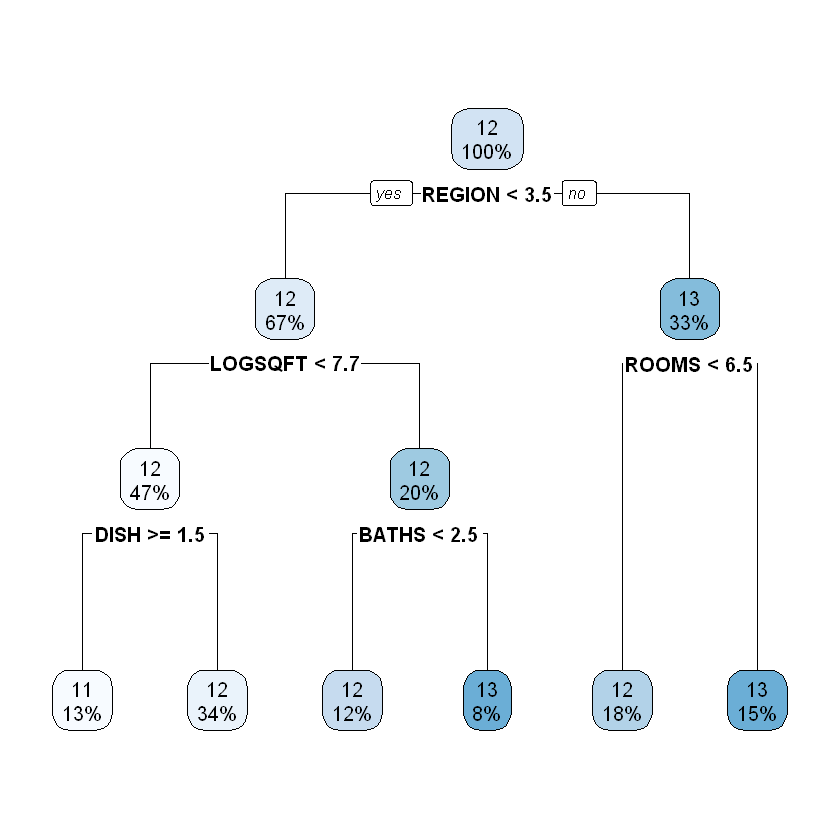

In [7]:
rpart.plot(fit_tree)

We see predicted (rounded) values for this tree above the frequency of those predictions. The interpretation is very easy as well. Consider a value of $REGION$ less than 3.5. The tree tells us that if this is the case we move to the left side. Then we see if the $LOGSQFT$ is less than 7.7. If it is we move left, if not we move right. This process continuous for each node in the tree until the final nodes in the tree. 

## Performance

Let's see how we do on the validation set with this model.

In [8]:
yhat = predict(fit_tree,val1)
rmse = sqrt(mean((val1$LOGVALUE-yhat)^2))
cat('\nTree RMSE: ', rmse)


Tree RMSE:  1.026989

Trees are great for interpretation, but not the best for actual prediction. The RMSE we got is worse than the linear models we estimated in the previous module.

## Random Forests

One idea that is common in machine learning is to combine weak learners together and produce an ensemble. When one does this with trees the method is known as random forests. The basic idea is combine many shallow trees with only a subset of the covariates and average the predictions. As usual with these algorithms, there are many hyperparameters to choose. To get us started we will fix the number of trees we use to $10$. This is very small for a random forest, but we are just testing this out right now. A typically number of trees to use in practice would be around $200$. Another tuning parameter we need to determine is the number of covariates to split on. Remember that random forests reduce the correlation between trees by subsetting the covariates in each tree. Let's use cross-validation to determine this number over the choices $5,20$, and $50$.

In [9]:
# Grid for number of covariates
rf_grid = expand.grid(mtry = c(5, 20, 50), 
          splitrule = c("variance"), min.node.size=c(5))

# train and evaluate the random forest with 5-fold CV
fit_forest = train(formula,
                   data = train1, 
                   method = 'ranger',
                   trControl = 
                   trainControl(method = 'cv',
                                number = 5),
                   tuneGrid = rf_grid, 
                   num.trees=10
                  )

In [10]:
fit_forest$results

mtry,splitrule,min.node.size,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
5,variance,5,0.7575440,0.4338390,0.4865288,0.02467908,0.01865255,0.004566212
20,variance,5,0.7547295,0.4389676,0.4834030,0.02491404,0.01824040,0.004927640
50,variance,5,0.7651590,0.4274636,0.4903936,0.02311524,0.01609046,0.003048248


## Evaluating Random Forests

First of all we notice that we have a big reduction in RMSE when we use random forests over trees, regardless of the tuning parameter. Secondly the performance is similar across the three specifications although we would expect the RMSE to be best when the number of covariates used is not too small or too large. Why is this? Remember that when the number of covariates used approaches the total number then we are simply bagging trees. These trees will be too highly correlated and prediction will suffer. On the other hand if we use too few covariates the trees will not be able to learn interesting patterns in the data.


## Exercise: Module 5

In this module we have seen how to build a regression tree. In addition to estimating the model we saw how easy it was to build a graph based on the tree. This graph allows for a straightforward interpretation of the model. Unfortunately, while the interpretation was very intuitive, the model performance was not very good. To fix this problem we introduced random forests and explained a few of the tuning parameters that need to be adjusted. Let's see how the results of the previous section change when we allow the number of trees to grow.

1. Use the code from the previous section to cross-validate the number of covariates to split on
2. Do this for 100 and 200 Trees
4. Do the results become more clear?



In [11]:
rf_grid = expand.grid(mtry = c(5, 20, 50), 
          splitrule = c("variance"), min.node.size=c(5))

fit_forest = train(formula,
                   data = train1, 
                   method = 'ranger',
                   trControl = 
                   trainControl(method = 'cv',
                                number = 5),
                   tuneGrid = rf_grid, 
                   num.trees=100
                  )



In [12]:
fit_forest$results

mtry,splitrule,min.node.size,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
5,variance,5,0.7375806,0.4713926,0.4671395,0.01863317,0.01555739,0.003144467
20,variance,5,0.7282436,0.4754647,0.4572256,0.01832495,0.01627446,0.001407557
50,variance,5,0.7386321,0.4611721,0.4645287,0.01646741,0.01356619,0.001471482


In [13]:
rf_grid = expand.grid(mtry = c(5, 20, 50), 
          splitrule = c("variance"), min.node.size=c(5))

fit_forest = train(formula,
                   data = train1, 
                   method = 'ranger',
                   trControl = 
                   trainControl(method = 'cv',
                                number = 5),
                   tuneGrid = rf_grid, 
                   num.trees=200
                  )


Growing trees.. Progress: 59%. Estimated remaining time: 21 seconds.
Growing trees.. Progress: 59%. Estimated remaining time: 21 seconds.
Growing trees.. Progress: 62%. Estimated remaining time: 19 seconds.
Growing trees.. Progress: 47%. Estimated remaining time: 35 seconds.
Growing trees.. Progress: 55%. Estimated remaining time: 25 seconds.
Growing trees.. Progress: 96%. Estimated remaining time: 1 seconds.


In [14]:
fit_forest$results

mtry,splitrule,min.node.size,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
5,variance,5,0.7366961,0.4729927,0.4660978,0.02086416,0.010403174,0.005829540
20,variance,5,0.7272025,0.4769672,0.4565843,0.01889029,0.008669055,0.004170272
50,variance,5,0.7378720,0.4620754,0.4635447,0.01871886,0.009070040,0.004511271


As we expected, when the number of trees is allowed to grow larger, the "best" performing forest is the one that splits on 20 covariates. The difference isn't substantial, but we can save ourselves some time when searching for tuning parameters by restricting the grid to values not too small and not too large.